In [201]:
# @title
### EP2 MAC0417 / MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,#
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO #
# DESTE EP. #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM #
# DESONESTIDADE ACADÊMICA OU PLÁGIO. #
# #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP. #
# #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR #
# DESONESTIDADE ACADÊMICA. #
# #
# #
# Nome : # Mikhail Futorny
# NUSP : # 5258765
# Turma: # MAC0417
# Prof.: # Ronaldo Fumio Hashimoto
##################################################################

In [155]:
import numpy as np
from cv2 import resize
import os
import pandas as pd
from matplotlib import pyplot as plt


In [156]:
def RGB2gray(imagem):
    img_reduzida = resize(imagem, (0,0), fx=0.5, fy=0.5) #Fazemos a reducao  junto om o rgb
    rgb_gray = [0.2989, 0.5870, 0.1140]
    return np.dot(img_reduzida[..., :3], rgb_gray).astype(np.uint8)

In [157]:
def Contrast_Stretching(imagem):
    minimo = np.min(imagem)
    maximo = np.max(imagem)
    return ((imagem - minimo)/(maximo - minimo)*255).astype(np.uint8)


In [158]:
def Logaritmica(imagem, c):
    imagem_retorno = c * np.log1p(imagem)
    return np.uint8(np.clip(imagem_retorno, 0, 255))

In [159]:
def exponencial(imagem, c, gamma):
    imagem_retorno = c * np.power(imagem, gamma)
    return np.uint8(np.clip(imagem_retorno, 0, 255))

In [160]:
def Laplaciano(imagem):

    laplacian_kernel = np.array([ #Kernel que vamos usar para a convolucao (Sobol)
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])

    rows, cols = imagem.shape
    img_laplacian = np.zeros((rows, cols), dtype=np.float64)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            img_laplacian[i, j] = (
                laplacian_kernel[0, 0] * imagem[i - 1, j - 1] +
                laplacian_kernel[0, 1] * imagem[i - 1, j] +
                laplacian_kernel[0, 2] * imagem[i - 1, j + 1] +
                laplacian_kernel[1, 0] * imagem[i, j - 1] +
                laplacian_kernel[1, 1] * imagem[i, j] +
                laplacian_kernel[1, 2] * imagem[i, j + 1] +
                laplacian_kernel[2, 0] * imagem[i + 1, j - 1] +
                laplacian_kernel[2, 1] * imagem[i + 1, j] +
                laplacian_kernel[2, 2] * imagem[i + 1, j + 1]
            )
    img_laplacian = np.clip(img_laplacian, 0, 255)

    return img_laplacian.astype(np.uint8)

In [161]:
def mean_filter(img, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    rows, cols = img.shape
    pad_size = kernel_size // 2
    padded_img = np.pad(img, pad_size, mode='constant', constant_values=0) #Padding para aplicarmos o Kernel
    filtered_img = np.zeros_like(img)

    for i in range(rows):
        for j in range(cols):
            filtered_img[i, j] = np.sum(kernel * padded_img[i:i+kernel_size, j:j+kernel_size])

    return filtered_img.astype(np.uint8)

In [162]:
def apply_augmentations(image, hyperparams):
    gray_image = RGB2gray(image) #Aplicamos a diminuição da imagem para ocupar menos espaço
    augmented_images = {
        'Normal': gray_image,
        'Logaritmo': Logaritmica(gray_image, hyperparams['c_log']),
        'Exponencial': exponencial(gray_image, hyperparams['c_exp'], hyperparams['gamma_exp']),
        'Laplaciano': Laplaciano(gray_image),
        'MeanFilter': mean_filter(gray_image),
        'Contraste': Contrast_Stretching(gray_image)
    }
    return augmented_images

In [163]:
hyperparams = {
    'Interno_Dia': {'c_log': 1, 'c_exp': 1, 'gamma_exp': 1.2}, #Tipos de iluminação. Para mais escuros, valores de c mais altos e gammas mais baixos
    'Externo_Dia': {'c_log': 1, 'c_exp': 1, 'gamma_exp': 1.2},
    'Interno_Noite': {'c_log': 2.5, 'c_exp': 2.5, 'gamma_exp': 0.3},
    'Externo_Noite': {'c_log': 2, 'c_exp': 2, 'gamma_exp': 0.8}
}

In [164]:
def Seleciona_Params(interno_externo, dia_noite):
    nome = f"{interno_externo}_{dia_noite}"
    return hyperparams[nome]

In [165]:
def display_images(images_dict): #funcao de print
    plt.figure(figsize=(10, 8))
    for i, (title, img) in enumerate(images_dict.items()):
        plt.subplot(2, 3, i + 1)
        plt.title(title)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

In [166]:
def CarregaImagens(dataset_folder):
    imagens = []
    for filename in os.listdir(dataset_folder):
        if filename.lower().endswith('.jpeg'):
            filepath = os.path.join(dataset_folder, filename)
            img = plt.imread(filepath)
            imagens.append((filename, img))
    return imagens

In [167]:
dataset_folder = './content/Dados'
metadata_path = './content/Metadados/metadados.csv'

augmented_folder_base = './content/augmentedDataSet'
os.makedirs(augmented_folder_base, exist_ok=True)

normal_folder = os.path.join(augmented_folder_base, 'Normal')
logaritmo_folder = os.path.join(augmented_folder_base, 'Logaritmo')
contraste_folder = os.path.join(augmented_folder_base, 'Contraste')
exponencial_folder = os.path.join(augmented_folder_base, 'Exponencial')
laplaciano_folder = os.path.join(augmented_folder_base, 'Laplaciano')
mean_filter_folder = os.path.join(augmented_folder_base, 'MeanFilter')

# Cria os diretorios
for folder in [normal_folder, logaritmo_folder, exponencial_folder, laplaciano_folder, mean_filter_folder, contraste_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

metadata = pd.read_csv(metadata_path)

In [168]:
imagens = CarregaImagens(dataset_folder)
augmented_metadata = []



In [169]:
for filename, img in imagens:

    meta = metadata[metadata['File Name'] == filename].iloc[0]
    dia_noite = meta['Dia/Noite']
    interno_externo = meta['Interno/Externo']

    hyperparams_selected = Seleciona_Params(interno_externo, dia_noite)

    augmented_images = apply_augmentations(img, hyperparams_selected)

    for aug_name, aug_img in augmented_images.items():
        aug_folder = os.path.join(augmented_folder_base, aug_name)
        save_path = os.path.join(aug_folder, filename)
        plt.imsave(save_path, aug_img, cmap='gray')

        new_meta = meta.copy()
        new_meta['Transformation'] = aug_name
        augmented_metadata.append(new_meta)



augmented_metadata_df = pd.DataFrame(augmented_metadata)
#Salvamos os novos metadados
augmented_metadata_df.to_csv(os.path.join(augmented_folder_base, 'augmented_metadados.csv'), index=False)


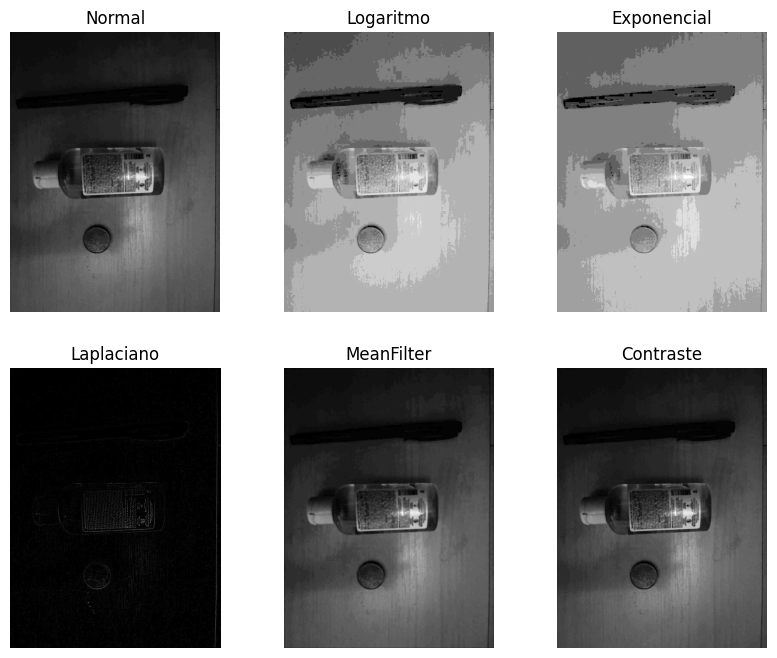

In [171]:

# Exemplo de visualização
example_filename, example_img = imagens[0]
example_meta = metadata[metadata['File Name'] == example_filename].iloc[0]
example_hyperparams = Seleciona_Params(example_meta['Interno/Externo'], example_meta['Dia/Noite'])
augmented_images = apply_augmentations(example_img, example_hyperparams)
display_images(augmented_images)